<a href="https://colab.research.google.com/github/olalepek/Text-Mining---Agriculture/blob/main/%5BRule_Matching%5D_Agriculture_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rispy pandas
!pip install plotly

In [ ]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rispy
!python -m spacy download en_core_web_sm
import spacy
import re
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy.matcher import DependencyMatcher
from spacy.matcher import PhraseMatcher
import plotly.express as px
import functions.py
import ast

# Rule Based Matching


### Entity Ruler based on the dictionary provided


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Studia DSE/abstracts_lemmatized_topic_classified.csv')


In [ ]:
rules_df = pd.read_excel('/content/drive/MyDrive/Studia DSE/Agro Text Mining/ontologia-02022022-3.xlsx')


In [ ]:
rules_df.info()
rules_df.columns=["Category", "Subcategory", "Pattern","1","2"]
rules_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Annotation (sono tutte cause del SOC)  587 non-null    object        
 1   Livello intermedio                     587 non-null    object        
 2   Subtext                                587 non-null    object        
 3   Note                                   20 non-null     object        
 4   Data aggiunta / modifica               215 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 23.1+ KB


,Category,Subcategory,Pattern,1,2
0,BARE SOIL,BARE SOIL,bare soil,NaN,NaT
1,BARE SOIL,BARE SOIL,fallow,NaN,NaT
2,BARE SOIL,BARE SOIL,no cover crop,NaN,2022-01-04
3,BARE SOIL,BARE SOIL,uncultivated,NaN,NaT
4,BARE SOIL,BARE SOIL,without cover crop,NaN,2022-01-04


> Using Category ("annotation") as a label in the entity ruler to start from the higher level of hierarchy and not miss the dependencies.




In [ ]:
patterns = [{"label": row["Category"], "pattern": row["Pattern"]} for index, row in rules_df.iterrows()]
print(patterns)

[{'label': 'BARE SOIL', 'pattern': 'bare soil'}, {'label': 'BARE SOIL', 'pattern': 'fallow'}, {'label': 'BARE SOIL', 'pattern': 'no cover crop'}, {'label': 'BARE SOIL', 'pattern': 'uncultivated'}, {'label': 'BARE SOIL', 'pattern': 'without cover crop'}, {'label': 'CONSERVATION AGRICULTURE', 'pattern': 'conservation agriculture'}, {'label': 'CONSERVATION AGRICULTURE', 'pattern': 'conservation farming'}, {'label': 'CONSERVATION AGRICULTURE', 'pattern': 'conservation practice'}, {'label': 'CONSERVATION AGRICULTURE', 'pattern': 'conservation tillage'}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'conventional tillage '}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'conventionally tilled'}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'CT'}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'inversion tillage '}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'tillage reversal'}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'traditional tillage'}, {'label': 'CONVENTIONAL TILLAGE', 'pattern': 'mo

In [ ]:
pattern_change = [
    {"label": "INCREASE", "pattern": [{"TEXT": {"REGEX": "increase|raise|enhance|boost|accelerate|aid|contribute|enable|enhance|facilitate|gain|greater|make more|positive effect|positively contribute|positively influence|promote|stimulate"}}]},
    {"label": "DECREASE", "pattern": [{"TEXT": {"REGEX": "decrease|drop|reduce|lower|diminish|decline|negative effect|reduction|suppress"}}]},
    {"label": "NEUTRAL", "pattern": [{"TEXT": {"REGEX": "no effect|unchange|remain the same|no significant (change|difference|impact)|be maintained|be similar|conserve|insignificant|lack of effect|maintain|no effect|non significant|not affect|not alter|not change|not contribute|not differ|not enable|not impact|not respond|not result|not show effect|not significantly affect|not significantly alter|not significantly change|not significantly contribute|not significantly differ|not significantly enable|not significantly impact|not significantly reduce|not significantly respond|not significantly result|similar|be stable"}}]}
]

In [ ]:
nlp = spacy.load("en_core_web_sm")
ruler = nlp.add_pipe("entity_ruler", before = "ner")
ruler.add_patterns(patterns)
ruler.add_patterns(pattern_change)


In [ ]:
ruler_patterns = ruler.patterns

# Display the first 20 patterns
for pattern in ruler_patterns[:10]:
    print(pattern)

{'label': 'INCREASE', 'pattern': [{'TEXT': {'REGEX': 'increase|raise|enhance|boost|accelerate|aid|contribute|enable|enhance|facilitate|gain|greater|make more|positive effect|positively contribute|positively influence|promote|stimulate'}}]}
{'label': 'DECREASE', 'pattern': [{'TEXT': {'REGEX': 'decrease|drop|reduce|lower|diminish|decline|negative effect|reduction|suppress'}}]}
{'label': 'NEUTRAL', 'pattern': [{'TEXT': {'REGEX': 'no effect|unchange|remain the same|no significant (change|difference|impact)|be maintained|be similar|conserve|insignificant|lack of effect|maintain|no effect|non significant|not affect|not alter|not change|not contribute|not differ|not enable|not impact|not respond|not result|not show effect|not significantly affect|not significantly alter|not significantly change|not significantly contribute|not significantly differ|not significantly enable|not significantly impact|not significantly reduce|not significantly respond|not significantly result|similar|be stable'}}]

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_nautral_matches.csv')

In [ ]:

dataset["ents"] = dataset["abstract"].apply(lambda abstract: [(ent.text, ent.label_) for ent in nlp(abstract).ents])

In [ ]:
dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_entity_rules.csv', index=False)

### Matcher

Matcher looks more for a pattern in the text and entity ruler can be used to identify specific entities within the text

In [ ]:
# "[INCREASE SOC"
pattern_soc_increase = [
  # anchor ent label: increase/decrease
  {
    "RIGHT_ID": "Change",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['INCREASE']}},
  },
  # Increase/decrease -> SOC
  {
    "LEFT_ID": "Change",
    "REL_OP": ">",
    "RIGHT_ID": "SOC",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['SOC']}}
  },
]


matcher = DependencyMatcher(nlp.vocab)
matcher.add("SOC INCREASE Pattern", [pattern_soc_increase])


In [ ]:
def matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = []
    for match_id, token_ids in matches:
        match_text = ' '.join([doc[i].text for i in token_ids])
        match_texts.append(match_text)
    return match_texts

dataset['matches'] = dataset['abstract'].apply(matcher_abstracts)

dataset.head()

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,ents,matches
0,Differences in Herbicide Adsorption on Soil Us...,J. Environ. Sci. Health Part B Pestic. Food Co...,1988,"['Clay, S.A.', 'Koskinen, W.C.', 'Allmaras, R....",Effects of soil pH on weak acid and weak base ...,"['atrazine', 'dicamba', 'atrazine', 'dicamba',...","Journal of Environmental Science and Health, P...","['Cited By :19', 'Export Date: 30 April 2020']",Article,effect soil ph weak acid weak base herbicid ad...,effect of soil ph on weak acid and weak base h...,effect soil ph weak acid weak base herbicide a...,"['effect', 'soil', 'ph', 'weak', 'acid', 'weak...",7,"[(pH, SOIL CHEMICAL PROPERTIES), (pH, SOIL CHE...",[]
1,Agroforestry on alkali soil: effect of plantin...,Agroforest Syst,1988,"['Singh, G.', 'Abrol, I.P.', 'Cheema, S.S.']",Growth responses of mesquite (Prosopis juliflo...,"['Agroforestry', 'alkali soil', 'amendments', ...",Agroforestry Systems,"['Cited By :18', 'Export Date: 30 April 2020',...",Article,growth respons mesquit prosopi juliflora sw dc...,growth response of mesquite ( Prosopis juliflo...,growth response mesquite prosopis juliflora sw...,"['growth', 'response', 'mesquite', 'prosopis',...",12,"[(SW, GPE), (Aquic Natrustalf, ORG), (the Cent...",[]
2,Fertilizer requirement of rice-wheat and maize...,Fertilizer Research,1988,"['Maskina, M.S.', 'Bijay-Singh', 'Yadvinder-Si...",Field experiments with rice-wheat rotation wer...,"['farmyard manure', 'maize', 'nitrogen', 'phos...",Fertilizer Research,"['Cited By :24', 'Export Date: 30 April 2020',...",Article,field experi rice wheat rotat conduct five con...,field experiment with rice - wheat rotation be...,field experiment rice wheat rotation conduct f...,"['field', 'experiment', 'rice', 'wheat', 'rota...",3,"[(five consecutive years, DATE), (12, CARDINAL...",[]
3,Effects of different levels of chemical Nitrog...,Fertilizer Research,1988,"['Singh, A.L.', 'Singh, P.K.', 'Lata, P.']",Application of higher levels (60 and 90 kg N h...,"['Azolla pinnata (Bangkok)', 'blue-green algae...",Fertilizer Research,"['Cited By :4', 'Export Date: 30 April 2020', ...",Article,applic higher level kg n ha nitrogen fertil ur...,application of high level ( 60 and 90 kg N ha-...,application high level kg n ha nitrogen fertil...,"['application', 'high', 'level', 'kg', 'n', 'h...",3,"[(60, CARDINAL), (Azolla, ORG), (Bangkok, GPE)...",[]
4,Correlation of several soil N indices for wheat,Commun. Soil Sci. Plant Anal.,1988,"['Gelderman, R.H.', 'Dahnke, W.C.', 'Swenson, ...",A study relating N uptake by wheat to several ...,"['mineralizable nitrogen', 'mineralization', '...",Communications in Soil Science and Plant Analysis,"['Cited By :11', 'Export Date: 30 April 2020']",Article,studi relat n uptak wheat sever n soil test co...,a study relate N uptake by wheat to several n ...,study relate n uptake wheat several n soil tes...,"['study', 'relate', 'n', 'uptake', 'wheat', 's...",2,"[(N, ORG), (N, GPE), (North and South Dakota, ...",[]


In [ ]:
filtered_df = dataset[dataset['matches'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1163 entries, 10 to 16640
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       1163 non-null   object
 1   alternate_title1            1163 non-null   object
 2   year                        1163 non-null   int64 
 3   authors                     1163 non-null   object
 4   abstract                    1163 non-null   object
 5   keywords                    1163 non-null   object
 6   secondary_title             1163 non-null   object
 7   notes                       1163 non-null   object
 8   type_of_work                1163 non-null   object
 9   processed_porter_stemmer    1163 non-null   object
 10  lemmatized_text             1163 non-null   object
 11  processed_lemmatized        1163 non-null   object
 12  abstract_tokens_lemmatized  1163 non-null   object
 13  dominant_topic              1163 non-null   int64 


In [ ]:
filtered_df.head()

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,ents,matches
10,Linking on-station research with on-farm testi...,Agroforest Syst,1988,"['Yamoah, C.F.', 'Grosz, R.']",Hillside farming with its attendant erosion an...,"['cover crops', 'leguminous shrubs', 'organic ...",Agroforestry Systems,"['Cited By :2', 'Export Date: 30 April 2020', ...",Article,hillsid farm attend eros declin soil fertil co...,hillside farm with its attendant erosion and d...,hillside farm attendant erosion decline soil f...,"['hillside', 'farm', 'attendant', 'erosion', '...",19,"[(erosion, SOIL PROCESSES), (decline, DECREASE...",[increase matter]
44,Measurement of soil microbial biomass provides...,Soil Biol. Biochem.,1987,"['Powlson, D.S.', 'Prookes, P.C.', 'Christense...",The straw and stubble of spring barley (Hordeu...,"['barley', 'Hordeum vulgare', 'straw/stubble']",Soil Biology and Biochemistry,"['Cited By :865', 'Export Date: 30 April 2020'...",Article,straw stubbl spring barley hordeum vulgar dri ...,the straw and stubble of spring barley ( Horde...,straw stubble spring barley hordeum vulgare dr...,"['straw', 'stubble', 'spring', 'barley', 'hord...",17,"[(spring, DATE), (5, CARDINAL), (annually, DAT...",[increased C]
68,FARMER'S ODE TO COMPOSTING.,BioCycle,1985,"['Holden, Craig']",Five years of practical field research at Hold...,"['CONSERVATION', 'FERTILIZERS', 'SOILS - Condi...",BioCycle,"['Export Date: 30 April 2020', 'CODEN: BCYCD',...",Article,five year practic field research holden farm a...,five year of practical field research at Holde...,five year practical field research holden farm...,"['five', 'year', 'practical', 'field', 'resear...",16,"[(Five years, DATE), (Holden Farms, ORG), (man...",[increased matter]
118,Changes in soil physical properties due to org...,J. ENVIRON. QUAL.,1981,"['Khaleel, R.', 'Reddy, K.R.', 'Overcash, M.R.']",The available data on effects of waste applica...,"['Waste disposal', 'LAND APPLICATION', 'Soils'...",Journal of Environmental Quality,"['Cited By :334', 'Export Date: 30 April 2020'...",Article,avail data effect wast applic soil physic prop...,the available datum on effect of waste applica...,available datum effect waste application soil ...,"['available', 'datum', 'effect', 'waste', 'app...",5,"[(bulk density, SOIL PHYSICAL PROPERTIES), (wa...","[increases organic, increases C, increases org..."
130,On the value of soil columns for assessing the...,Water Air Soil Pollut,1979,"['Bitton, G.', 'Davidson, J.M.', 'Farrah, S.R.']",The U.S. Water Pollution Control Act Amendment...,"['SOIL POLLUTION', 'sludge disposal', 'soil', ...","Water, Air, and Soil Pollution","['Cited By :19', 'Export Date: 30 April 2020',...",Article,u water pollut control act amend pl made land ...,the U.S. Water Pollution Control Act Amendment...,u water pollution control act amendment pl mak...,"['u', 'water', 'pollution', 'control', 'act', ...",19,[(The U.S. Water Pollution Control Act Amendme...,[increased soil]


In [ ]:
 dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_matches.csv')

In [ ]:
# "[DECREASE ... SOC"
pattern_soc_decrease = [
  # anchor ent label: increase/decrease
  {
    "RIGHT_ID": "Change",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['DECREASE']}},
  },
  # Increase/decrease -> SOC
  {
    "LEFT_ID": "Change",
    "REL_OP": ">",
    "RIGHT_ID": "SOC",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['SOC']}}
  },
]


matcher = DependencyMatcher(nlp.vocab)
matcher.add("SOC DECREASE Pattern", [pattern_soc_decrease])
dataset['matches_decrease_SOC'] = dataset['abstract'].apply(matcher_abstracts)

In [ ]:


dataset['matches_decrease_SOC'] = dataset['abstract'].apply(matcher_abstracts)

dataset.head()

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,ents,matches,matches_decrease_SOC
0,Differences in Herbicide Adsorption on Soil Us...,J. Environ. Sci. Health Part B Pestic. Food Co...,1988,"['Clay, S.A.', 'Koskinen, W.C.', 'Allmaras, R....",Effects of soil pH on weak acid and weak base ...,"['atrazine', 'dicamba', 'atrazine', 'dicamba',...","Journal of Environmental Science and Health, P...","['Cited By :19', 'Export Date: 30 April 2020']",Article,effect soil ph weak acid weak base herbicid ad...,effect of soil ph on weak acid and weak base h...,effect soil ph weak acid weak base herbicide a...,"['effect', 'soil', 'ph', 'weak', 'acid', 'weak...",7,"[(pH, SOIL CHEMICAL PROPERTIES), (pH, SOIL CHE...",[],[]
1,Agroforestry on alkali soil: effect of plantin...,Agroforest Syst,1988,"['Singh, G.', 'Abrol, I.P.', 'Cheema, S.S.']",Growth responses of mesquite (Prosopis juliflo...,"['Agroforestry', 'alkali soil', 'amendments', ...",Agroforestry Systems,"['Cited By :18', 'Export Date: 30 April 2020',...",Article,growth respons mesquit prosopi juliflora sw dc...,growth response of mesquite ( Prosopis juliflo...,growth response mesquite prosopis juliflora sw...,"['growth', 'response', 'mesquite', 'prosopis',...",12,"[(SW, GPE), (Aquic Natrustalf, ORG), (the Cent...",[],[]
2,Fertilizer requirement of rice-wheat and maize...,Fertilizer Research,1988,"['Maskina, M.S.', 'Bijay-Singh', 'Yadvinder-Si...",Field experiments with rice-wheat rotation wer...,"['farmyard manure', 'maize', 'nitrogen', 'phos...",Fertilizer Research,"['Cited By :24', 'Export Date: 30 April 2020',...",Article,field experi rice wheat rotat conduct five con...,field experiment with rice - wheat rotation be...,field experiment rice wheat rotation conduct f...,"['field', 'experiment', 'rice', 'wheat', 'rota...",3,"[(five consecutive years, DATE), (12, CARDINAL...",[],[]
3,Effects of different levels of chemical Nitrog...,Fertilizer Research,1988,"['Singh, A.L.', 'Singh, P.K.', 'Lata, P.']",Application of higher levels (60 and 90 kg N h...,"['Azolla pinnata (Bangkok)', 'blue-green algae...",Fertilizer Research,"['Cited By :4', 'Export Date: 30 April 2020', ...",Article,applic higher level kg n ha nitrogen fertil ur...,application of high level ( 60 and 90 kg N ha-...,application high level kg n ha nitrogen fertil...,"['application', 'high', 'level', 'kg', 'n', 'h...",3,"[(60, CARDINAL), (Azolla, ORG), (Bangkok, GPE)...",[],[]
4,Correlation of several soil N indices for wheat,Commun. Soil Sci. Plant Anal.,1988,"['Gelderman, R.H.', 'Dahnke, W.C.', 'Swenson, ...",A study relating N uptake by wheat to several ...,"['mineralizable nitrogen', 'mineralization', '...",Communications in Soil Science and Plant Analysis,"['Cited By :11', 'Export Date: 30 April 2020']",Article,studi relat n uptak wheat sever n soil test co...,a study relate N uptake by wheat to several n ...,study relate n uptake wheat several n soil tes...,"['study', 'relate', 'n', 'uptake', 'wheat', 's...",2,"[(N, ORG), (N, GPE), (North and South Dakota, ...",[],[]


In [ ]:
filtered_df = dataset[dataset['matches_decrease_SOC'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 274 to 16577
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       276 non-null    object
 1   alternate_title1            276 non-null    object
 2   year                        276 non-null    int64 
 3   authors                     276 non-null    object
 4   abstract                    276 non-null    object
 5   keywords                    276 non-null    object
 6   secondary_title             276 non-null    object
 7   notes                       276 non-null    object
 8   type_of_work                276 non-null    object
 9   processed_porter_stemmer    276 non-null    object
 10  lemmatized_text             276 non-null    object
 11  processed_lemmatized        276 non-null    object
 12  abstract_tokens_lemmatized  276 non-null    object
 13  dominant_topic              276 non-null    int64 


In [ ]:
 dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_matches.csv')

In [ ]:
# "[NEUTRAL ... SOC"
pattern_soc_neutral = [
  # anchor ent label: increase/decrease
  {
    "RIGHT_ID": "Change",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['NEUTRAL']}},
  },
  # Increase/decrease -> SOC
  {
    "LEFT_ID": "Change",
    "REL_OP": ">",
    "RIGHT_ID": "SOC",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['SOC']}}
  },
]


matcher = DependencyMatcher(nlp.vocab)
matcher.add("SOC NEUTRAL Pattern", [pattern_soc_neutral])
def matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = []
    for match_id, token_ids in matches:
        match_text = ' '.join([doc[i].text for i in token_ids])
        match_texts.append(match_text)
    return match_texts

dataset['matches_neutral_SOC'] = dataset['abstract'].apply(matcher_abstracts)

dataset.head()

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,ents,matches_increase_SOC,matches_decrease_SOC,matches_neutral_SOC
0,Differences in Herbicide Adsorption on Soil Us...,J. Environ. Sci. Health Part B Pestic. Food Co...,1988,"['Clay, S.A.', 'Koskinen, W.C.', 'Allmaras, R....",Effects of soil pH on weak acid and weak base ...,"['atrazine', 'dicamba', 'atrazine', 'dicamba',...","Journal of Environmental Science and Health, P...","['Cited By :19', 'Export Date: 30 April 2020']",Article,effect soil ph weak acid weak base herbicid ad...,effect of soil ph on weak acid and weak base h...,effect soil ph weak acid weak base herbicide a...,"['effect', 'soil', 'ph', 'weak', 'acid', 'weak...",7,"[(pH, SOIL CHEMICAL PROPERTIES), (pH, SOIL CHE...",[],[],[]
1,Agroforestry on alkali soil: effect of plantin...,Agroforest Syst,1988,"['Singh, G.', 'Abrol, I.P.', 'Cheema, S.S.']",Growth responses of mesquite (Prosopis juliflo...,"['Agroforestry', 'alkali soil', 'amendments', ...",Agroforestry Systems,"['Cited By :18', 'Export Date: 30 April 2020',...",Article,growth respons mesquit prosopi juliflora sw dc...,growth response of mesquite ( Prosopis juliflo...,growth response mesquite prosopis juliflora sw...,"['growth', 'response', 'mesquite', 'prosopis',...",12,"[(SW, GPE), (Aquic Natrustalf, ORG), (the Cent...",[],[],[]
2,Fertilizer requirement of rice-wheat and maize...,Fertilizer Research,1988,"['Maskina, M.S.', 'Bijay-Singh', 'Yadvinder-Si...",Field experiments with rice-wheat rotation wer...,"['farmyard manure', 'maize', 'nitrogen', 'phos...",Fertilizer Research,"['Cited By :24', 'Export Date: 30 April 2020',...",Article,field experi rice wheat rotat conduct five con...,field experiment with rice - wheat rotation be...,field experiment rice wheat rotation conduct f...,"['field', 'experiment', 'rice', 'wheat', 'rota...",3,"[(five consecutive years, DATE), (12, CARDINAL...",[],[],[]
3,Effects of different levels of chemical Nitrog...,Fertilizer Research,1988,"['Singh, A.L.', 'Singh, P.K.', 'Lata, P.']",Application of higher levels (60 and 90 kg N h...,"['Azolla pinnata (Bangkok)', 'blue-green algae...",Fertilizer Research,"['Cited By :4', 'Export Date: 30 April 2020', ...",Article,applic higher level kg n ha nitrogen fertil ur...,application of high level ( 60 and 90 kg N ha-...,application high level kg n ha nitrogen fertil...,"['application', 'high', 'level', 'kg', 'n', 'h...",3,"[(60, CARDINAL), (Azolla, ORG), (Bangkok, GPE)...",[],[],[]
4,Correlation of several soil N indices for wheat,Commun. Soil Sci. Plant Anal.,1988,"['Gelderman, R.H.', 'Dahnke, W.C.', 'Swenson, ...",A study relating N uptake by wheat to several ...,"['mineralizable nitrogen', 'mineralization', '...",Communications in Soil Science and Plant Analysis,"['Cited By :11', 'Export Date: 30 April 2020']",Article,studi relat n uptak wheat sever n soil test co...,a study relate N uptake by wheat to several n ...,study relate n uptake wheat several n soil tes...,"['study', 'relate', 'n', 'uptake', 'wheat', 's...",2,"[(N, ORG), (N, GPE), (North and South Dakota, ...",[],[],[]


In [ ]:
filtered_df = dataset[dataset['matches_neutral_SOC'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 389 to 16373
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       122 non-null    object
 1   alternate_title1            122 non-null    object
 2   year                        122 non-null    int64 
 3   authors                     122 non-null    object
 4   abstract                    122 non-null    object
 5   keywords                    122 non-null    object
 6   secondary_title             122 non-null    object
 7   notes                       122 non-null    object
 8   type_of_work                122 non-null    object
 9   processed_porter_stemmer    122 non-null    object
 10  lemmatized_text             122 non-null    object
 11  processed_lemmatized        122 non-null    object
 12  abstract_tokens_lemmatized  122 non-null    object
 13  dominant_topic              122 non-null    int64 


In [ ]:
 dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_nautral_matches.csv')

In [ ]:
# "SOC Increase"
matcher = Matcher(nlp.vocab)
pattern_socincrease = [{"ENT_TYPE": {"IN":['SOC INCREASE']}}]

matcher.add("Tillage", [pattern_socincrease])

def regular_matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = [doc[start:end].text for _, start, end in matches]
    return match_texts

dataset['SOC_Increase'] = dataset['abstract'].apply(regular_matcher_abstracts)

In [ ]:
filtered_df = dataset[dataset['SOC_Increase'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 175 to 16609
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       594 non-null    object
 1   alternate_title1            594 non-null    object
 2   year                        594 non-null    int64 
 3   authors                     594 non-null    object
 4   abstract                    594 non-null    object
 5   keywords                    594 non-null    object
 6   secondary_title             594 non-null    object
 7   notes                       594 non-null    object
 8   type_of_work                594 non-null    object
 9   processed_porter_stemmer    594 non-null    object
 10  lemmatized_text             594 non-null    object
 11  processed_lemmatized        594 non-null    object
 12  abstract_tokens_lemmatized  594 non-null    object
 13  dominant_topic              594 non-null    int64 


In [ ]:
 dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_nautral_matches.csv')

In [ ]:
# "SOC Decrease"
matcher = Matcher(nlp.vocab)
pattern_socdecrease = [{"ENT_TYPE": {"IN":['SOC DECREASE']}}]

matcher.add("SOC Decrease", [pattern_socdecrease])

def regular_matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = [doc[start:end].text for _, start, end in matches]
    return match_texts

dataset['SOC_Decrease'] = dataset['abstract'].apply(regular_matcher_abstracts)

In [ ]:
filtered_df = dataset[dataset['SOC_Decrease'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 691 entries, 11 to 16636
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       691 non-null    object
 1   alternate_title1            691 non-null    object
 2   year                        691 non-null    int64 
 3   authors                     691 non-null    object
 4   abstract                    691 non-null    object
 5   keywords                    691 non-null    object
 6   secondary_title             691 non-null    object
 7   notes                       691 non-null    object
 8   type_of_work                691 non-null    object
 9   processed_porter_stemmer    691 non-null    object
 10  lemmatized_text             691 non-null    object
 11  processed_lemmatized        691 non-null    object
 12  abstract_tokens_lemmatized  691 non-null    object
 13  dominant_topic              691 non-null    int64 
 

In [ ]:
dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_nautral_matches.csv')

In [ ]:
datasset =pd.read_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_nautral_matches.csv')

In [ ]:
# "[Icrease COS ... Tillage"
pattern_soc_positive_NT = [
  # anchor ent label: increase/decrease
  {
    "RIGHT_ID": "Change",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['MINIMUM TILLAGE', 'NO TILLAGE']}},
  },
  # Increase/decrease -> SOC
  {
    "LEFT_ID": "Change",
    "REL_OP": "<",
    "RIGHT_ID": "SOC",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['SOC INCREASE']}}
  },
]


matcher = DependencyMatcher(nlp.vocab)
matcher.add("SOC_plus_NT", [pattern_soc_positive_NT])
def matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = []
    for match_id, token_ids in matches:
        match_text = ' '.join([doc[i].text for i in token_ids])
        match_texts.append(match_text)
    return match_texts

dataset['soc_positive_NT_MT'] = dataset['abstract'].apply(matcher_abstracts)

In [ ]:
filtered_df = dataset[dataset['soc_positive_plus_NT_MT'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 12905 to 12905
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  1 non-null      int64 
 1   title                       1 non-null      object
 2   alternate_title1            1 non-null      object
 3   year                        1 non-null      int64 
 4   authors                     1 non-null      object
 5   abstract                    1 non-null      object
 6   keywords                    1 non-null      object
 7   secondary_title             1 non-null      object
 8   notes                       1 non-null      object
 9   type_of_work                1 non-null      object
 10  processed_porter_stemmer    1 non-null      object
 11  lemmatized_text             1 non-null      object
 12  processed_lemmatized        1 non-null      object
 13  abstract_tokens_lemmatized  1 non-null      object


In [ ]:
filtered_df.head()

,Unnamed: 0,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,...,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,ents,matches_increase_SOC,matches_decrease_SOC,matches_neutral_SOC,SOC_Increase,SOC_Decrease,soc_positive_NT_MT
12905,12905,Soil organic carbon sequestration and agricult...,Soil Tillage Res.,2005,"['Franzluebbers, A.J.']",Agriculture in the southeastern USA can be hig...,"['Conservation tillage', 'Cover crop', 'Grazin...",Soil and Tillage Research,"['Cited By :197', 'Export Date: 30 April 2020'...",Conference Paper,...,agriculture southeastern usa highly productive...,"['agriculture', 'southeastern', 'usa', 'highly...",10,"[(USA, GPE), (soil organic C, SOC), (SOC, SOC)...",['increased SOC'],[],[],"['SOC', 'sequestration', 'SOC', 'sequestration...",[],[NT sequestration]


In [ ]:

pattern_soc_negative_NT = [
  # anchor ent label: increase/decrease
  {
    "RIGHT_ID": "Change",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['MINIMUM TILLAGE', 'NO TILLAGE']}},
  },
  # Increase/decrease -> SOC
  {
    "LEFT_ID": "Change",
    "REL_OP": "<",
    "RIGHT_ID": "SOC",
    "RIGHT_ATTRS": {"ENT_TYPE": {"IN":['SOC DECREASE']}}
  },
]


matcher = DependencyMatcher(nlp.vocab)
matcher.add("SOC_minus_NT", [pattern_soc_negative_NT])
def matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = []
    for match_id, token_ids in matches:
        match_text = ' '.join([doc[i].text for i in token_ids])
        match_texts.append(match_text)
    return match_texts

dataset['soc_negative_NT_MT'] = dataset['abstract'].apply(matcher_abstracts)

In [ ]:
filtered_df = dataset[dataset['soc_negative_NT_MT'].apply(lambda x: len(x) > 0)]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  0 non-null      int64 
 1   title                       0 non-null      object
 2   alternate_title1            0 non-null      object
 3   year                        0 non-null      int64 
 4   authors                     0 non-null      object
 5   abstract                    0 non-null      object
 6   keywords                    0 non-null      object
 7   secondary_title             0 non-null      object
 8   notes                       0 non-null      object
 9   type_of_work                0 non-null      object
 10  processed_porter_stemmer    0 non-null      object
 11  lemmatized_text             0 non-null      object
 12  processed_lemmatized        0 non-null      object
 13  abstract_tokens_lemmatized  0 non-null      object
 14  dominant_to

In [ ]:
dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_positive_negative_nautral_matches.csv')

### Identyfing only MINIMAL or NO TILLAGE practices

In [ ]:
# "tillage"
matcher = Matcher(nlp.vocab)
pattern_tillage = [{"ENT_TYPE": {"IN":['MINIMUM TILLAGE','NO TILLAGE']}}]

matcher.add("Tillage", [pattern_tillage])

def regular_matcher_abstracts(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = [doc[start:end].text for _, start, end in matches]
    return match_texts

filtered_df['tillage'] = filtered_df['abstract'].apply(regular_matcher_abstracts)


<ipython-input-28-f120cf9149d1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tillage'] = filtered_df['abstract'].apply(regular_matcher_abstracts)


In [ ]:
tillage_increase_soc = filtered_df[filtered_df['tillage'].apply(lambda x: len(x) > 0)]
tillage_increase_soc.head()

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,matches,tillage
166,Disposal of composted municipal waste in a pla...,J. ENVIRON. QUAL.,1973,"['Bengtson, G.W.', 'Cornette, J.J.']",Potential hazards in the agricultural and home...,"['Municipal engineering', 'Waste utilization',...",Journal of Environmental Quality,"['Cited By :43', 'Export Date: 30 April 2020',...",Article,potenti hazard agricultur home garden use comm...,potential hazard in the agricultural and home ...,potential hazard agricultural home garden use ...,"['potential', 'hazard', 'agricultural', 'home'...",15,[increased matter],"[disking, disking, disking]"
274,Changes in soil organic carbon stocks under 10...,J. Agric. Sci.,2016,"['Liang, A.Z.', 'Yang, X.M.', 'Zhang, X.P.', '...",Biased assessment of tillage impacts on soil o...,"['assessment method', 'carbon sequestration', ...",Journal of Agricultural Science,"['Cited By :12', 'Export Date: 30 April 2020',...",Article,bias assess tillag impact soil organ carbon so...,biased assessment of tillage impact on soil or...,biased assessment tillage impact soil organic ...,"['biased', 'assessment', 'tillage', 'impact', ...",1,"[increase SOC, increase SOC]","[NT, ridge, tillage, RT, NT, RT, NT, RT, NT, R..."
363,Tillage and crop rotation effects on carbon se...,S. Afr. J. Plant Soil,2016,"['Njaimwe, A.N.', 'Mnkeni, P.N.S.', 'Chiduza, ...",Intensive tillage and monocropping have advers...,"['aggregate stability', 'carbon sequestration'...",South African Journal of Plant and Soil,"['Cited By :2', 'Export Date: 30 April 2020', ...",Article,intens tillag monocrop advers affect qualiti s...,intensive tillage and monocropping have advers...,intensive tillage monocropping adversely affec...,"['intensive', 'tillage', 'monocropping', 'adve...",1,[enhanced SOC],[NT]
435,Greenhouse gas emissions in a spring wheat–fie...,Nutr. Cycl. Agroecosyst.,2016,"['Yeboah, S.', 'Zhang, R.', 'Cai, L.', 'Song, ...",Greenhouse gas emissions from agriculture prod...,"['Greenhouse gas', 'No tillage', 'Rain-fed', '...",Nutrient Cycling in Agroecosystems,"['Cited By :17', 'Export Date: 30 April 2020',...",Article,greenhous ga emiss agricultur product predict ...,greenhouse gas emission from agriculture produ...,greenhouse gas emission agriculture production...,"['greenhouse', 'gas', 'emission', 'agriculture...",1,[increase carbon],"[NT, NT, NT]"
526,Long term effect of conservation agriculture i...,Soil Tillage Res.,2016,"['Parihar, C.M.', 'Yadav, M.R.', 'Jat, S.L.', ...",Maize-based crop rotations are advocated as al...,"['Diversified crop rotations', 'Enzymatic acti...",Soil and Tillage Research,"['Cited By :60', 'Export Date: 30 April 2020',...",Article,maiz base crop rotat advoc altern rice base sy...,maize - base crop rotation be advocate as alte...,maize base crop rotation advocate alternate ri...,"['maize', 'base', 'crop', 'rotation', 'advocat...",1,"[enhance carbon, increased carbon]","[ZT, ZT, ZT, ZT, ZT]"


In [ ]:
tillage_increase_soc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 166 to 16602
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       244 non-null    object
 1   alternate_title1            244 non-null    object
 2   year                        244 non-null    int64 
 3   authors                     244 non-null    object
 4   abstract                    244 non-null    object
 5   keywords                    244 non-null    object
 6   secondary_title             244 non-null    object
 7   notes                       244 non-null    object
 8   type_of_work                244 non-null    object
 9   processed_porter_stemmer    244 non-null    object
 10  lemmatized_text             244 non-null    object
 11  processed_lemmatized        244 non-null    object
 12  abstract_tokens_lemmatized  244 non-null    object
 13  dominant_topic              244 non-null    in

In [ ]:
tillage_increase_soc.to_csv('/content/drive/MyDrive/Studia DSE/abstract_with_matches_tillage.csv')

## Processing all abstracts with the terminology

In [ ]:
all_data = pd.read_csv('/content/drive/MyDrive/Studia DSE/all_data_processed_w_c.csv')
excel_terms = '/content/drive/MyDrive/Studia DSE/Agro Text Mining/ontologia.xlsx'

In [ ]:
find_matches_for_characteristics('country', excel_terms,'country','title','processed_lemmatized',all_data)

List of all sheets in the excel file loaded: ['ontologia', 'climates', 'soils', 'crops', 'cause ed effetti', 'termini aggiuntivi per direz', 'benchmark', 'country', 'continent']
List of characteristics ['aruba', 'afghanistan', 'angola', 'anguilla', 'åland islands', 'albania', 'andorra', 'united arab emirates', 'argentina', 'armenia', 'american samoa', 'antarctica', 'french southern territories', 'antigua and barbuda', 'australia', 'austria', 'azerbaijan', 'burundi', 'belgium', 'benin', 'bonaire, sint eustatius and saba', 'burkina faso', 'bangladesh', 'bulgaria', 'bahrain', 'bahamas', 'bosnia and herzegovina', 'saint barthélemy', 'belarus', 'belize', 'bermuda', 'bolivia, plurinational state of', 'brazil', 'barbados', 'brunei darussalam', 'bhutan', 'bouvet island', 'botswana', 'central african republic', 'canada', 'cocos (keeling) islands', 'switzerland', 'chile', 'china', "côte d'ivoire", 'cameroon', 'congo, the democratic republic of the', 'congo', 'cook islands', 'colombia', 'comoros'

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,country
0,Differences in Herbicide Adsorption on Soil Us...,J. Environ. Sci. Health Part B Pestic. Food Co...,1988,"['Clay, S.A.', 'Koskinen, W.C.', 'Allmaras, R....",Effects of soil pH on weak acid and weak base ...,"['atrazine', 'dicamba', 'atrazine', 'dicamba',...","Journal of Environmental Science and Health, P...","['Cited By :19', 'Export Date: 30 April 2020']",Article,effect soil ph weak acid weak base herbicid ad...,effect of soil ph on weak acid and weak base h...,effect soil ph weak acid weak base herbicide a...,"['effect', 'soil', 'ph', 'weak', 'acid', 'weak...",7,[]
1,Agroforestry on alkali soil: effect of plantin...,Agroforest Syst,1988,"['Singh, G.', 'Abrol, I.P.', 'Cheema, S.S.']",Growth responses of mesquite (Prosopis juliflo...,"['Agroforestry', 'alkali soil', 'amendments', ...",Agroforestry Systems,"['Cited By :18', 'Export Date: 30 April 2020',...",Article,growth respons mesquit prosopi juliflora sw dc...,growth response of mesquite ( Prosopis juliflo...,growth response mesquite prosopis juliflora sw...,"['growth', 'response', 'mesquite', 'prosopis',...",12,[]
2,Fertilizer requirement of rice-wheat and maize...,Fertilizer Research,1988,"['Maskina, M.S.', 'Bijay-Singh', 'Yadvinder-Si...",Field experiments with rice-wheat rotation wer...,"['farmyard manure', 'maize', 'nitrogen', 'phos...",Fertilizer Research,"['Cited By :24', 'Export Date: 30 April 2020',...",Article,field experi rice wheat rotat conduct five con...,field experiment with rice - wheat rotation be...,field experiment rice wheat rotation conduct f...,"['field', 'experiment', 'rice', 'wheat', 'rota...",3,[]
3,Effects of different levels of chemical Nitrog...,Fertilizer Research,1988,"['Singh, A.L.', 'Singh, P.K.', 'Lata, P.']",Application of higher levels (60 and 90 kg N h...,"['Azolla pinnata (Bangkok)', 'blue-green algae...",Fertilizer Research,"['Cited By :4', 'Export Date: 30 April 2020', ...",Article,applic higher level kg n ha nitrogen fertil ur...,application of high level ( 60 and 90 kg N ha-...,application high level kg n ha nitrogen fertil...,"['application', 'high', 'level', 'kg', 'n', 'h...",3,[]
4,Correlation of several soil N indices for wheat,Commun. Soil Sci. Plant Anal.,1988,"['Gelderman, R.H.', 'Dahnke, W.C.', 'Swenson, ...",A study relating N uptake by wheat to several ...,"['mineralizable nitrogen', 'mineralization', '...",Communications in Soil Science and Plant Analysis,"['Cited By :11', 'Export Date: 30 April 2020']",Article,studi relat n uptak wheat sever n soil test co...,a study relate N uptake by wheat to several n ...,study relate n uptake wheat several n soil tes...,"['study', 'relate', 'n', 'uptake', 'wheat', 's...",2,[]


In [ ]:
country_map('country',all_data)

In [ ]:
all_data.to_csv('/content/drive/MyDrive/Studia DSE/all_data_processed_w_c.csv', index=False)

In [ ]:
find_matches_for_characteristics('climate', excel_terms,'climates','title','processed_lemmatized',all_data)


List of all sheets in the excel file loaded: ['ontologia', 'climates', 'soils', 'crops', 'cause ed effetti', 'termini aggiuntivi per direz', 'benchmark', 'country', 'continent']
List of characteristics ['tropical', 'dry', 'arid', 'semi-arid', 'temperate', 'mediterranean', 'humid subtropical', 'oceanic', 'subpolar', 'dry-winter humid subtropical', 'dry-winter subtropical oceanic', 'dry-winter subpolar oceanic', 'continental', 'hemiboreal', 'subarctic', 'boreal', 'polar', 'tundra', 'ice cap', 'subtropical', 'sub-humid', 'humid', 'highland']


,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,country,climate
0,Differences in Herbicide Adsorption on Soil Us...,J. Environ. Sci. Health Part B Pestic. Food Co...,1988,"['Clay, S.A.', 'Koskinen, W.C.', 'Allmaras, R....",Effects of soil pH on weak acid and weak base ...,"['atrazine', 'dicamba', 'atrazine', 'dicamba',...","Journal of Environmental Science and Health, P...","['Cited By :19', 'Export Date: 30 April 2020']",Article,effect soil ph weak acid weak base herbicid ad...,effect of soil ph on weak acid and weak base h...,effect soil ph weak acid weak base herbicide a...,"['effect', 'soil', 'ph', 'weak', 'acid', 'weak...",7,[],[]
1,Agroforestry on alkali soil: effect of plantin...,Agroforest Syst,1988,"['Singh, G.', 'Abrol, I.P.', 'Cheema, S.S.']",Growth responses of mesquite (Prosopis juliflo...,"['Agroforestry', 'alkali soil', 'amendments', ...",Agroforestry Systems,"['Cited By :18', 'Export Date: 30 April 2020',...",Article,growth respons mesquit prosopi juliflora sw dc...,growth response of mesquite ( Prosopis juliflo...,growth response mesquite prosopis juliflora sw...,"['growth', 'response', 'mesquite', 'prosopis',...",12,[],[]
2,Fertilizer requirement of rice-wheat and maize...,Fertilizer Research,1988,"['Maskina, M.S.', 'Bijay-Singh', 'Yadvinder-Si...",Field experiments with rice-wheat rotation wer...,"['farmyard manure', 'maize', 'nitrogen', 'phos...",Fertilizer Research,"['Cited By :24', 'Export Date: 30 April 2020',...",Article,field experi rice wheat rotat conduct five con...,field experiment with rice - wheat rotation be...,field experiment rice wheat rotation conduct f...,"['field', 'experiment', 'rice', 'wheat', 'rota...",3,[],[]
3,Effects of different levels of chemical Nitrog...,Fertilizer Research,1988,"['Singh, A.L.', 'Singh, P.K.', 'Lata, P.']",Application of higher levels (60 and 90 kg N h...,"['Azolla pinnata (Bangkok)', 'blue-green algae...",Fertilizer Research,"['Cited By :4', 'Export Date: 30 April 2020', ...",Article,applic higher level kg n ha nitrogen fertil ur...,application of high level ( 60 and 90 kg N ha-...,application high level kg n ha nitrogen fertil...,"['application', 'high', 'level', 'kg', 'n', 'h...",3,[],[dry]
4,Correlation of several soil N indices for wheat,Commun. Soil Sci. Plant Anal.,1988,"['Gelderman, R.H.', 'Dahnke, W.C.', 'Swenson, ...",A study relating N uptake by wheat to several ...,"['mineralizable nitrogen', 'mineralization', '...",Communications in Soil Science and Plant Analysis,"['Cited By :11', 'Export Date: 30 April 2020']",Article,studi relat n uptak wheat sever n soil test co...,a study relate N uptake by wheat to several n ...,study relate n uptake wheat several n soil tes...,"['study', 'relate', 'n', 'uptake', 'wheat', 's...",2,[],[]


<class 'pandas.core.frame.DataFrame'>
Index: 4249 entries, 3 to 16673
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       4249 non-null   object
 1   alternate_title1            4249 non-null   object
 2   year                        4249 non-null   int64 
 3   authors                     4249 non-null   object
 4   abstract                    4249 non-null   object
 5   keywords                    4249 non-null   object
 6   secondary_title             4249 non-null   object
 7   notes                       4249 non-null   object
 8   type_of_work                4249 non-null   object
 9   processed_porter_stemmer    4249 non-null   object
 10  lemmatized_text             4249 non-null   object
 11  processed_lemmatized        4249 non-null   object
 12  abstract_tokens_lemmatized  4249 non-null   object
 13  dominant_topic              4249 non-null   int64 
 

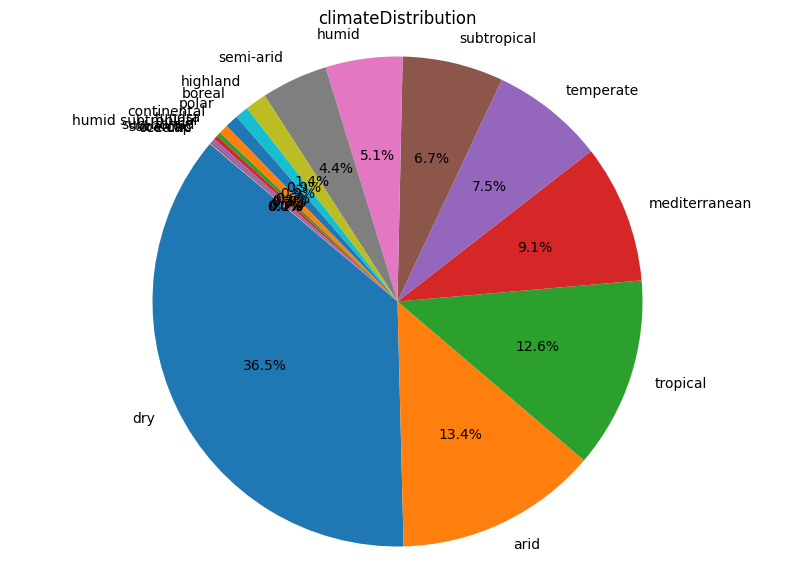

In [ ]:
pie_chart_characteristics('climate',all_data)

In [ ]:
find_matches_for_characteristics('soil', excel_terms,'soils','title','processed_lemmatized',all_data)
find_matches_for_characteristics('crop', excel_terms,'crops','title','processed_lemmatized',all_data)

List of all sheets in the excel file loaded: ['ontologia', 'climates', 'soils', 'crops', 'cause ed effetti', 'termini aggiuntivi per direz', 'benchmark', 'country', 'continent']
List of characteristics ['artificially drained soil', 'drained soil', 'marsh soil', 'poorly drained soil', 'undrained soil', 'waterlogged soil', 'well drained soil', 'acid soil', 'calcareous soil', 'neutral soil', 'sodic soil', 'fertile soil', 'poor soil', 'mineral soil', 'organic soil', 'clay soil', 'clay loam soil', 'heavy soil', 'light soil', 'loam soil', 'loamy sand soil', 'medium soil', 'sand soil', 'sandy clay soil', 'sandy clay loam soil', 'sandy loam soil', 'sandy silt loam soil', 'silt soil', 'silt loam soil', 'silty clay soil', 'silty clay loam soil', 'vertisol', 'alfisol', 'aridisol', 'entisol', 'gelisol', 'histosol', 'inceptisol', 'mollisol', 'oxisol', 'spodosol', 'ultisol', 'vertisol', 'andisol', 'arenosol', 'calcisol', 'cambisol', 'chernozem', 'cryosol', 'durisol', 'ferralsol', 'fluvisol', 'gleyso

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


List of all sheets in the excel file loaded: ['ontologia', 'climates', 'soils', 'crops', 'cause ed effetti', 'termini aggiuntivi per direz', 'benchmark', 'country', 'continent']
List of characteristics ['barley', 'buckwheat', 'corn', 'maize', 'millet', 'oats', 'quinoa', 'rice', 'rye', 'sorghum', 'wheat', 'hordeum vulgare', 'zea mays', 'avena sativa', 'oryza sativa', 'secale cereale', 'triticum aestivum', 'triticum durum', 'triticum turgidum', 'triticosecale', 'panicum miliaceum', 'setaria italica', 'sorghum bicolor', 'fagopyrum esculentum', 'chenopodium quinoa', 'beans', 'chickpea', 'cowpea', 'vigna unguiculata', 'lentil', 'lupin', 'pea', 'soybean', 'cicer arietinum', 'glycine max', 'pisum sativum', 'phaseolus vulgaris', 'lens culinaris', 'lupinus albus', 'oilseed rape', 'brassica napus', 'oilseedrape', 'rapeseed', 'sunflower', 'helianthus annuus', 'sugar beet', 'beta vulgaris', 'sugar cane', 'saccharum officinarum', 'artichoke', 'asparagus', 'broccoli', 'brussels sprout', 'cabbage', '

,title,alternate_title1,year,authors,abstract,keywords,secondary_title,notes,type_of_work,processed_porter_stemmer,lemmatized_text,processed_lemmatized,abstract_tokens_lemmatized,dominant_topic,country,climate,soil,crop
0,Differences in Herbicide Adsorption on Soil Us...,J. Environ. Sci. Health Part B Pestic. Food Co...,1988,"['Clay, S.A.', 'Koskinen, W.C.', 'Allmaras, R....",Effects of soil pH on weak acid and weak base ...,"['atrazine', 'dicamba', 'atrazine', 'dicamba',...","Journal of Environmental Science and Health, P...","['Cited By :19', 'Export Date: 30 April 2020']",Article,effect soil ph weak acid weak base herbicid ad...,effect of soil ph on weak acid and weak base h...,effect soil ph weak acid weak base herbicide a...,"['effect', 'soil', 'ph', 'weak', 'acid', 'weak...",7,[],[],"[loam soil, silt loam soil]",[]


In [ ]:
all_data.to_csv('/content/drive/MyDrive/Studia DSE/all_data_processed_with terminology.csv', index=False)